In [ ]:
#import libraries

import pandas as pd
from prophet import Prophet
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

In [ ]:
#load data into dataframe

df = pd.read_csv("Nat_Gas.csv").set_index("Dates")

# set date to datetime index
df.index = pd.to_datetime(df.index)

#set prices as float
df["Prices"] = df["Prices"].astype(float)


In [ ]:
df.head()

,Prices
Dates,
2020-10-31,10.1
2020-11-30,10.3
2020-12-31,11.0
2021-01-31,10.9
2021-02-28,10.9


In [ ]:
df['days'] = (df.index - df.index.min()).days

# Create interpolation function
Cubic_spline = interp1d(df['days'], df['Prices'], kind='cubic', fill_value='extrapolate')


In [ ]:
df.head()

,Prices,days
Dates,,
2020-10-31,10.1,0
2020-11-30,10.3,30
2020-12-31,11.0,61
2021-01-31,10.9,92
2021-02-28,10.9,120


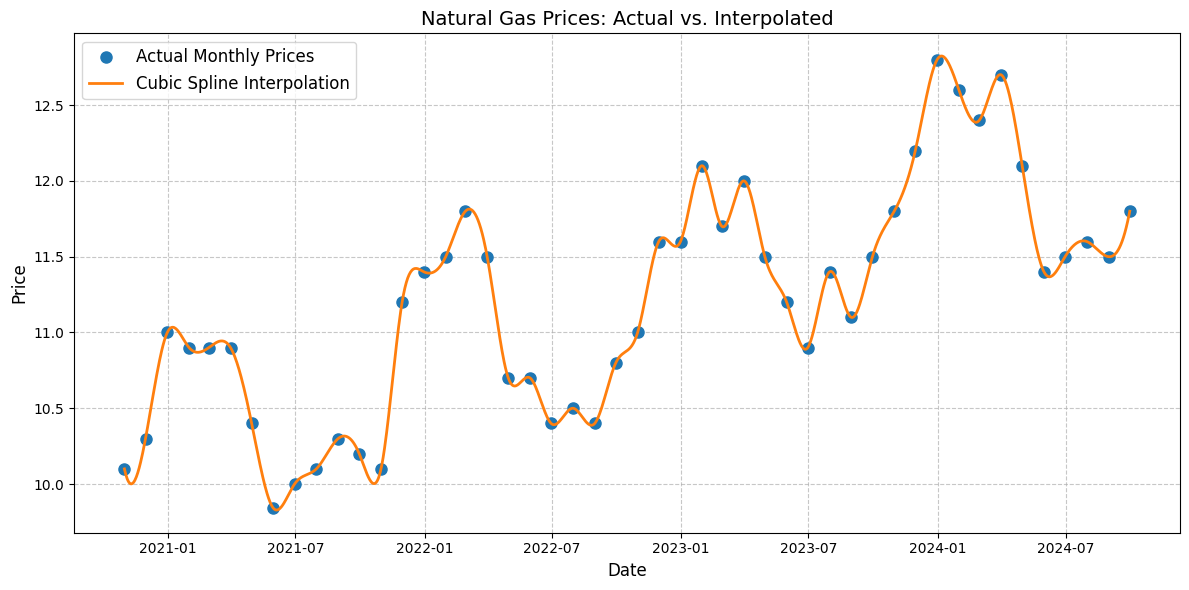

In [ ]:
daily_dates = pd.date_range(start=df.index.min(), end=df.index.max(), freq='D')
daily_days = (daily_dates - df.index.min()).days
interpolate_prices = Cubic_spline(daily_days)

# Plot settings
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Prices'], 'o', label='Actual Monthly Prices', markersize=8)
plt.plot(daily_dates, interpolate_prices, '-', label='Cubic Spline Interpolation', linewidth=2)

# Formatting
plt.title('Natural Gas Prices: Actual vs. Interpolated', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()


In [ ]:
#putting interpolated prices into data frame
df_inter=pd.DataFrame(interpolate_prices, index=daily_dates, columns=["Prices"])
df_inter.head()
df_inter.index.name = "Date"
type(df_inter.index)

pandas.core.indexes.datetimes.DatetimeIndex

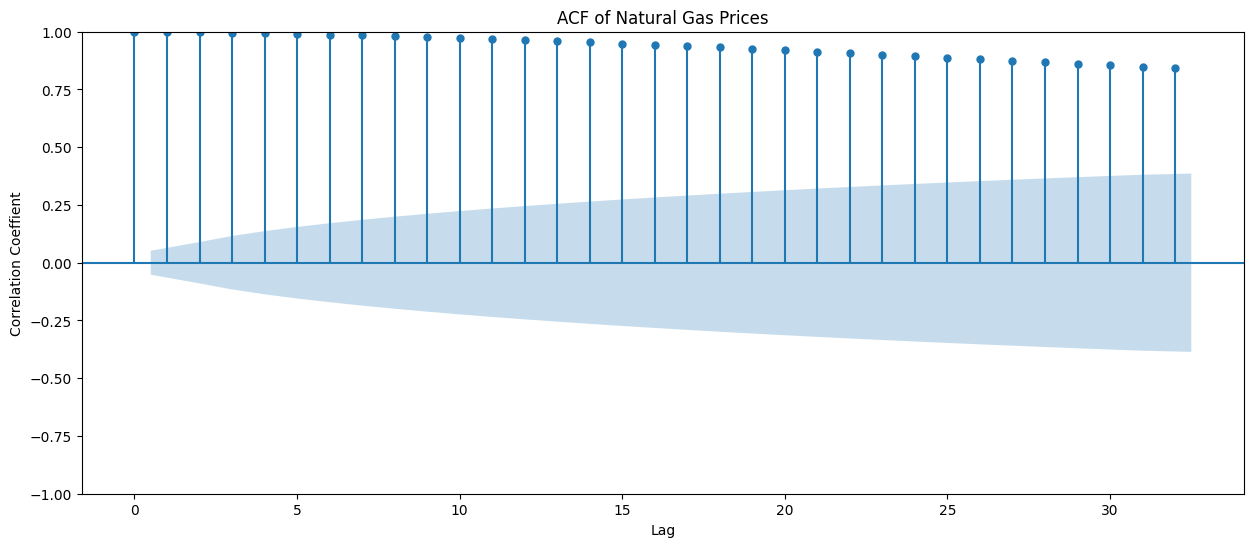

In [ ]:
#plotting acf

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, ax = plt.subplots(figsize=(15,6))

plot_acf(df_inter['Prices'], ax=ax)
plt.xlabel("Lag")
plt.ylabel("Correlation Coeffient")
plt.title("ACF of Natural Gas Prices")
plt.show()

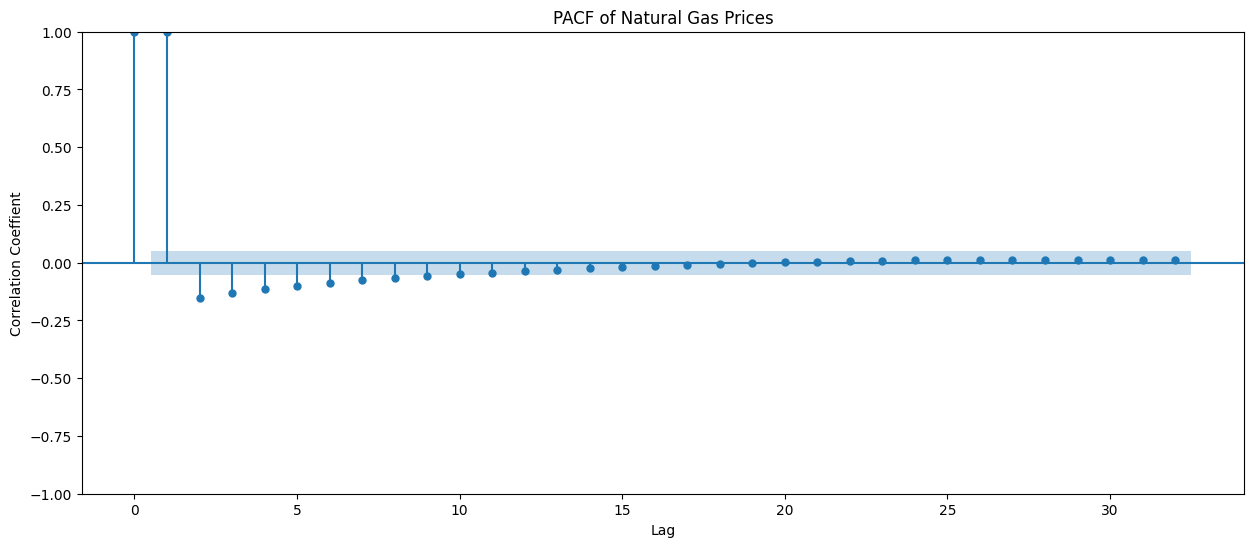

In [ ]:
#plotting pacf
fig, ax = plt.subplots(figsize=(15,6))

plot_pacf(df_inter['Prices'], ax=ax)
plt.xlabel("Lag")
plt.ylabel("Correlation Coeffient")
plt.title("PACF of Natural Gas Prices")
plt.show()

In [ ]:
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_absolute_error

In [ ]:
y= df_inter["Prices"]

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

In [ ]:
cutoff = int(len(y)*0.8)

In [ ]:
y_train = y[:cutoff]
y_test = y[cutoff:]

In [ ]:
#baseline
y_train_mean = y_train.mean()
y_pred_baseline = [y_train_mean] * len(y_train)
mae_baseline = mean_absolute_error(y_train, y_pred_baseline)
print(f"Baseline MAE: {mae_baseline:.2f}")

Baseline MAE: 0.54


In [ ]:
p = range(1,4)
maes =[]

for i in p:
  model = AutoReg(y_train, lags=i).fit()
  y_pred = model.predict().dropna()
  mae = mean_absolute_error(y_train.iloc[i:], y_pred)
  maes.append(mae)

mae_series = pd.Series(maes, name="mae", index=p)
mae_series.head()


,mae
1,0.010999
2,0.000703
3,0.000053


In [ ]:
model2 = ARIMA(y_train, order=(2,0,0)).fit()
y_pred2 = model2.predict().dropna()
mae2 = mean_absolute_error(y_train, y_pred2)
mae2


0.0015061436250680324

In [ ]:
#model summary
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 Prices   No. Observations:                 1144
Model:                 ARIMA(2, 0, 0)   Log Likelihood                6438.422
Date:                Mon, 11 Aug 2025   AIC                         -12868.843
Time:                        09:14:56   BIC                         -12848.674
Sample:                    10-31-2020   HQIC                        -12861.228
                         - 12-18-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.0009      0.059    186.436      0.000      10.885      11.117
ar.L1          1.9995      0.000   1.36e+04      0.000       1.999       2.000
ar.L2         -0.9999      0.000  -7031.737      0.000      -1.000      -1.000
sigma2      7.403e-07   3.42e-08     21.624      0.000    6.73e-07    8.07e-07
===================================================================================
Ljung-Box (L1) (Q):                1129.13   Jarque-Bera (JB):                15.73
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.87   Skew:                             0.26
Prob(H) (two-sided):                  0.00   Kurtosis:                         2.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
#walk foward validation on data
y_pred_wfv = pd.Series()
history = y_train.copy()
for i in range(len(y_test)):
    model = ARIMA(history, order=(2,0,0)).fit()
    next_pred = model.forecast(steps=1)
    y_pred_wfv = pd.concat([y_pred_wfv, next_pred])
    history = pd.concat([history, y_test.iloc[i:i+1]])



y_pred_wfv.name = "prediction"
y_pred_wfv.index.name = "date"
y_pred_wfv.head()

/tmp/ipython-input-1417019279.py:7: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  y_pred_wfv = pd.concat([y_pred_wfv, next_pred])
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat

,prediction
date,
2023-12-19,12.622064
2023-12-20,12.641941
2023-12-21,12.661125
2023-12-22,12.679549
2023-12-23,12.697150


In [ ]:
#comparison on the test data between test data and model predictions
df_predict = pd.concat([y_pred_wfv, y_test], axis=1)
df_predict.columns = ["prediction", "actual"]
df_predict.head()

,prediction,actual
2023-12-19,12.622064,12.622229
2023-12-20,12.641941,12.642050
2023-12-21,12.661125,12.661176
2023-12-22,12.679549,12.679544
2023-12-23,12.697150,12.697088


In [ ]:
df_predict.tail()

,prediction,actual
2024-09-26,11.710505,11.711821
2024-09-27,11.730776,11.732126
2024-09-28,11.752190,11.753573
2024-09-29,11.774772,11.776189
2024-09-30,11.798549,11.800000


In [ ]:
# checking mean absolute error
mae_pred = mean_absolute_error(y_test, y_pred_wfv)
print(f"ARIMA MAE: {mae_pred:.5f}")

ARIMA MAE: 0.00060


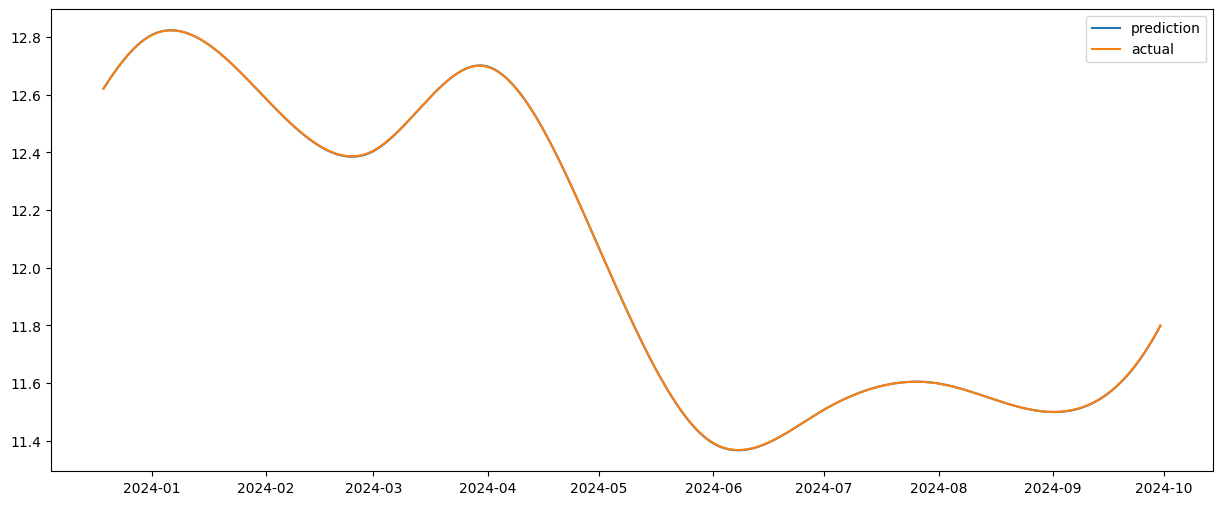

In [ ]:
# ploting test data and predictions
fig, ax = plt.subplots(figsize=(15, 6))

ax.plot(df_predict.index, df_predict["prediction"], label="prediction")
ax.plot(df_predict.index, df_predict["actual"], label="actual")

ax.legend()
plt.show()


In [ ]:
y.head()

,Prices
Date,
2020-10-31,10.100000
2020-11-01,10.079783
2020-11-02,10.062042
2020-11-03,10.046711
2020-11-04,10.033721


In [ ]:
# extrapolatinng price data into the future
extrapolate= model.forecast(steps=252)
extrapolate.tail()

,predicted_mean
2025-06-04,10.283137
2025-06-05,10.292318
2025-06-06,10.301808
2025-06-07,10.311604
2025-06-08,10.321700


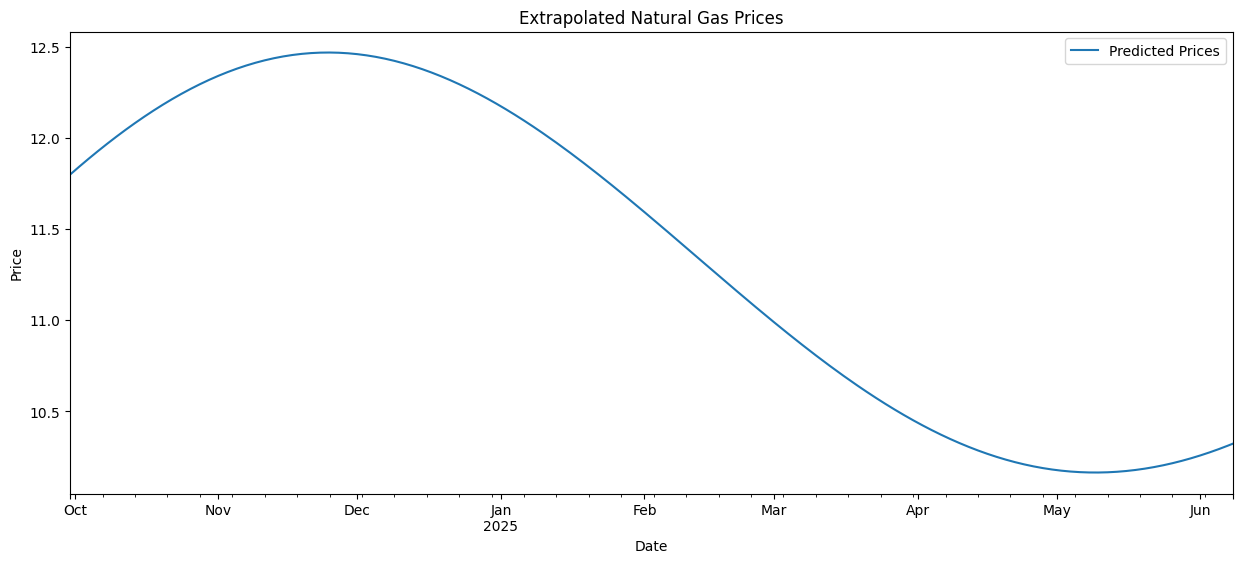

In [ ]:
# plotting predicted prices
extrapolate.plot(figsize=(15,6),label="Predicted Prices")
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Extrapolated Natural Gas Prices")
plt.legend()
plt.show()

In [ ]:
# adding data into one series
data = pd.concat([
    df_inter,
    extrapolate.rename('Prices')  # rename the Series itself
])

In [ ]:
data.tail()

,Prices
2025-06-04,10.283137
2025-06-05,10.292318
2025-06-06,10.301808
2025-06-07,10.311604
2025-06-08,10.321700


In [ ]:
#creating a function
def search(date_str):
    """
    Parameters:
        date_str (str): Date in 'YYYY-MM-DD' format

    """
    # Convert input string to datetime
    date = pd.to_datetime(date_str)

    # Check if date is in index
    if date in data.index:
        return data.loc[date, 'Prices']
    else:
        return "Data out of range"


In [ ]:
search("2021-08-15")

np.float64(10.19892469298426)